In [ ]:
# 텐서플로우 일일 빌드버전

!pip install -q tf-nightly

     |████████████████████████████████| 492.6 MB 21 kB/s 
     |████████████████████████████████| 5.8 MB 42.3 MB/s 
     |████████████████████████████████| 1.4 MB 60.5 MB/s 
     |████████████████████████████████| 462 kB 61.0 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pathlib를 통해 경로관리 편하게

import pathlib

path = pathlib.Path('/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더')

In [ ]:
path

PosixPath('/content/drive/MyDrive/T1_PJ/DATA/이미지 폴더')

In [ ]:
# 해당경로 하위에 있는 jpg 파일 개수 알아보기

image_count = len(list(path.glob('*/*.jpg')))
print(image_count)

15251


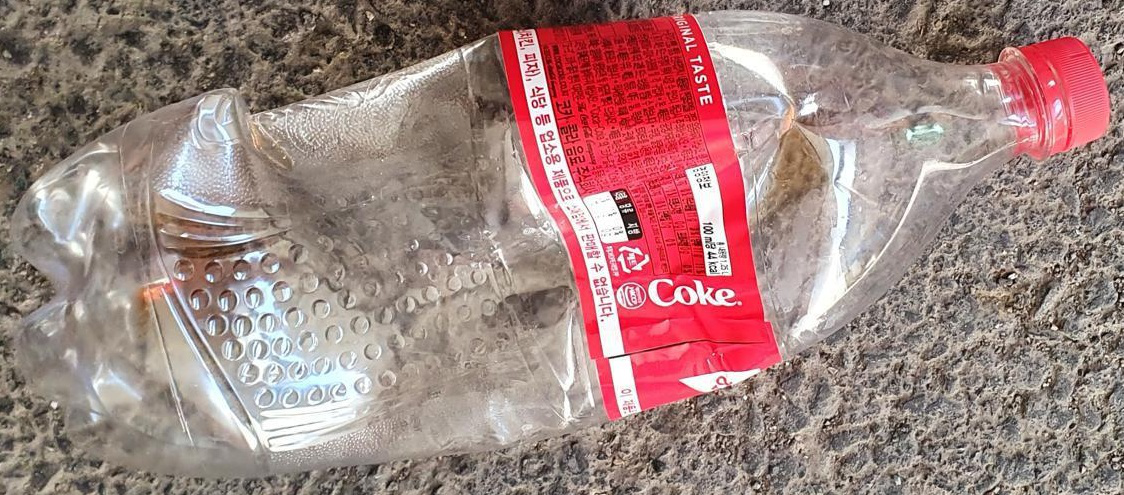

In [ ]:
# 해당위치의 첫번째 데이터

PET = list(path.glob('페트_페트병/*'))
PIL.Image.open(str(PET[0]))

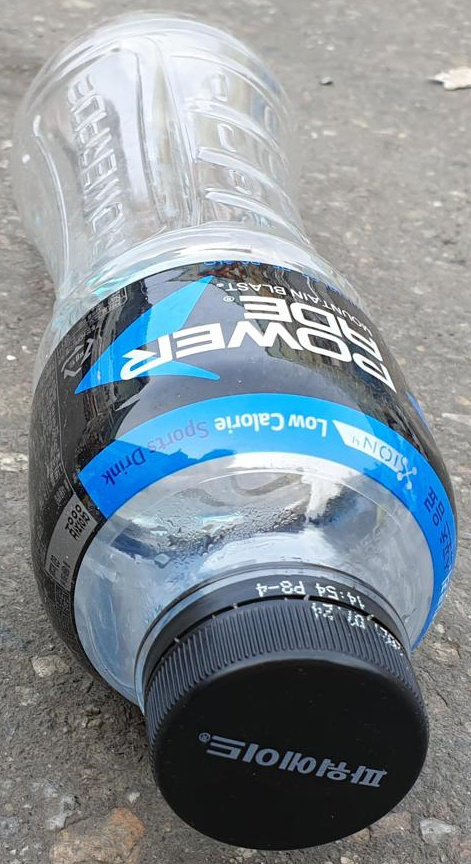

In [ ]:
PIL.Image.open(str(PET[1]))

In [ ]:
# 배치사이즈, 이미지 사이즈 설정

batch_size = 32
img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15280 files belonging to 3 classes.
Using 12224 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15280 files belonging to 3 classes.
Using 3056 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['잔여라벨', '재활용 가능 페트병', '페트_페트병']


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [ ]:
# 정규화 작업

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# 정규화 작업

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image)) 

0.00034107885 1.0


In [ ]:
# 어그멘테이션

#data_augmentation = keras.Sequential(
#  [
#    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
#    layers.experimental.preprocessing.RandomRotation(0.1),
#    layers.experimental.preprocessing.RandomZoom(0.1),
#  ]
#)

In [ ]:
# 어그멘테이션

#plt.figure(figsize=(10, 10))
#for images, _ in train_ds.take(1):
#  for i in range(9):
#    augmented_images = data_augmentation(images)
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(augmented_images[0].numpy().astype("uint8"))
#    plt.axis("off")

In [ ]:
# 모델 작성
# Dropout 사용

num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)       

In [ ]:
# 훈련

epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
382/382 [==============================] - ETA: 0s - loss: 0.0962 - accuracy: 0.9750WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fee503cb200> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set th

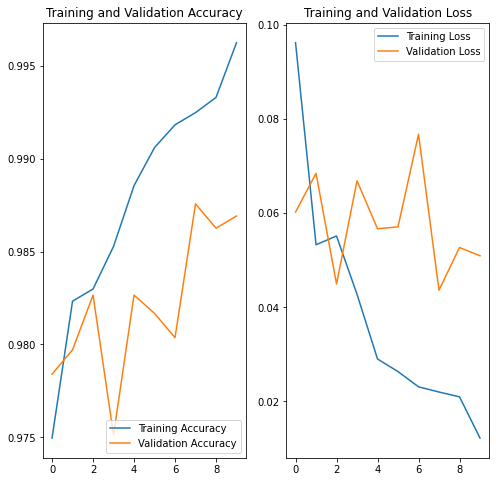

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

이 사진은 95.00076174736023% 확률로 재활용 가능 페트병 입니다


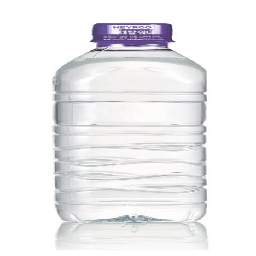

In [ ]:
# 예측1


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet8.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 100.0% 확률로 페트_페트병 입니다


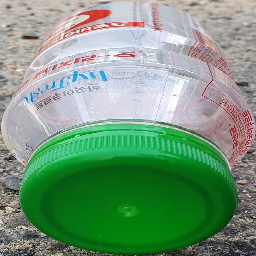

In [ ]:
# 예측2


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet2.jpg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

이 사진은 79.64285016059875% 확률로 페트_페트병 입니다


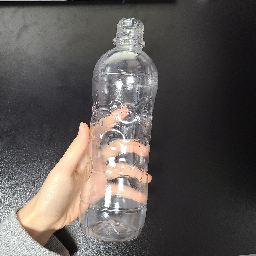

In [ ]:
# 예측


PET_path = '/content/drive/MyDrive/T1_PJ/DATA/test/pet9.jpeg'

img = keras.preprocessing.image.load_img(
    PET_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 사진은 " + str(100 * np.max(score)) + "% 확률로 " +  class_names[np.argmax(score)] + ' 입니다')
img

In [ ]:
# 모델 저장
#!pip install pyyaml h5py

In [ ]:
#model.save('/content/drive/MyDrive/T1_PJ/CODE/PET_model.h5') 